# GNN Training

In this notebook, a custom [PyTorch Geometric](https://rusty1s.github.io/pytorch_geometric/build/html/index.html) [InMemoryDataset](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/in_memory_dataset.html#InMemoryDataset) for the DAVIS 2016 dataset is created. The implementation is based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/create_dataset.html). The dataset is then used to train Graph Neural Networks as a first evaluation based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/introduction.html#learning-methods-on-graphs).

The dataset consists of single PyTorch Geometric [Data](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/data.html#Data) objects which model a single graph with various attributes. For this dataset, a graph for each contour is created. Hereby, each node of the graph represents one contour point. The feature of each node is the OSVOS feature vector from the next frame at this point. Each node is connected to its K nearest neighbours. The feature of each edge is the distance between the nodes it connects. The targets of each node is the translation it undergoes from the current to the next frame.

## Imports

In [3]:
import os

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler
from torch_geometric.data import DataLoader

from pg_networks.dynamic_edge import DynamicEdge
from pg_networks.gcn import GCN
from pg_networks.sg import SG
import src.config as cfg
from src.davis_2016 import DAVIS2016
from src.solver import Solver
from src.vis_utils import plot_img_with_contour_and_translation, plot_translations, plot_loss, \
                          plot_combo_img

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Paths & Constants

## Train and Val Dataset

In [ ]:
train = DAVIS2016(cfg.PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH,
                  cfg.ANNOTATIONS_AUGMENTED_FOLDERS_PATH, cfg.CONTOURS_FOLDERS_PATH, 
                  cfg.IMAGES_AUGMENTED_FOLDERS_PATH, cfg.TRANSLATIONS_FOLDERS_PATH,
                  cfg.PARENT_MODEL_PATH,
                  cfg.LAYER, cfg.K, cfg.EPOCHS_WO_AVEGRAD, cfg.AUGMENTATION_COUNT,
                  cfg.SKIP_SEQUENCES, cfg.TRAIN_SEQUENCES, cfg.VAL_SEQUENCES,
                  train=True)

Processing...
Create new OSVOS model...
Constructing OSVOS architecture..
Initializing weights..
#0: bear
	Augmentation #0
	Augmentation #1
	Augmentation #2
	Augmentation #3
	Augmentation #4
	Augmentation #5
	Augmentation #6
	Augmentation #7
	Augmentation #8
	Augmentation #9
	Augmentation #10
	Augmentation #11


In [ ]:
val = DAVIS2016(cfg.PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH,
                  cfg.ANNOTATIONS_AUGMENTED_FOLDERS_PATH, cfg.CONTOURS_FOLDERS_PATH, 
                  cfg.IMAGES_AUGMENTED_FOLDERS_PATH, cfg.TRANSLATIONS_FOLDERS_PATH,
                  cfg.PARENT_MODEL_PATH,
                  cfg.LAYER, cfg.K, cfg.EPOCHS_WO_AVEGRAD, 0,
                  cfg.SKIP_SEQUENCES, cfg.TRAIN_SEQUENCES, cfg.VAL_SEQUENCES,
                  train=False)

In [ ]:
print("Train size: %i" % len(train))
print("Val size: %i" % len(val))

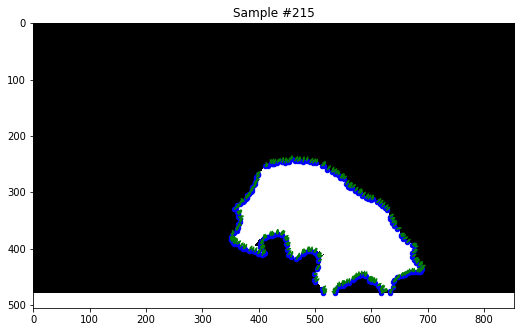

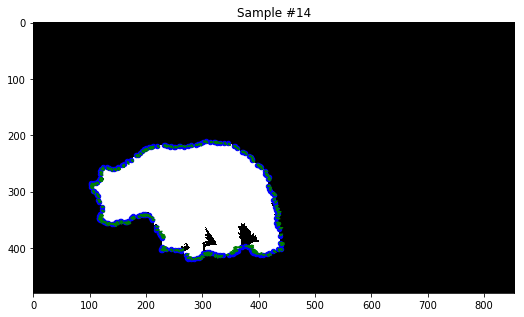

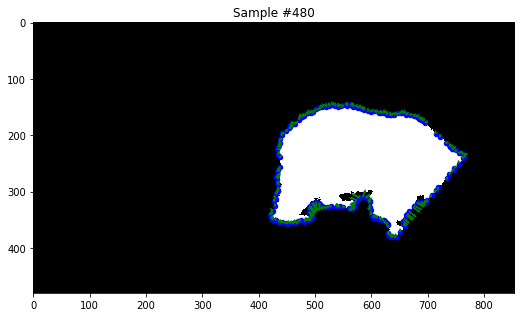

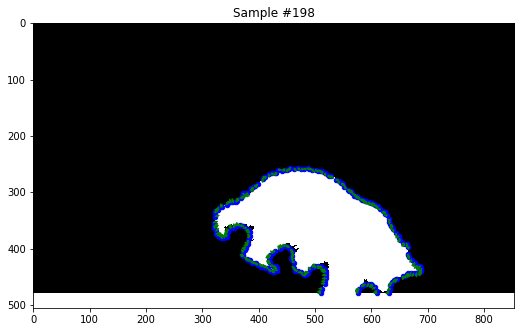

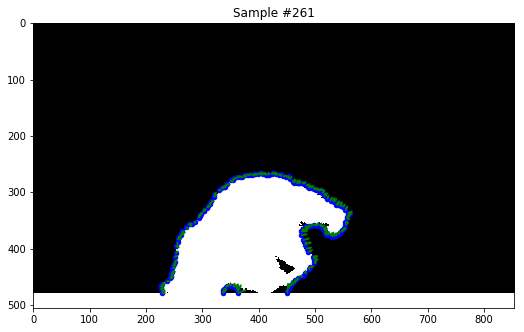

In [5]:
num_to_display = 5

for i in range(num_to_display):
    
    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(train))
    data = train[rand_i]
    
    # Load corresponding image
    processed_file_name = train.processed_file_names[rand_i]
    folder = processed_file_name[:-11]
    augmentation_count = processed_file_name[-10:-9]
    file_name = processed_file_name[-8:-3]
    
    image_path = os.path.join(val.raw_paths[0], folder, augmentation_count,
                                ('{}{}'.format(file_name, '.png')))
    
    image = imageio.imread(image_path)
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_img_with_contour_and_translation(image, data.contour, data.y)

## Simple GCN

In [6]:
data = train[0]

model = GCN(in_channels=data.num_features, 
            out_channels=data.y.shape[1])

print(model)

GCN(
  (conv1): GCNConv(256, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 1024)
  (conv4): GCNConv(1024, 1024)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
)


### Overfit

In [28]:
num_train = 80
num_val = 20

overfit_train_loader = DataLoader(train, batch_size=16, 
                                  shuffle=False, sampler=SequentialSampler(range(num_train)))
overfit_val_loader = DataLoader(train, batch_size=1, 
                                shuffle=False, sampler=SequentialSampler(range(num_val)))

# Load model and run the solver
overfit_model = GCN(in_channels=data.num_features, 
                    out_channels=data.y.shape[1])

overfit_solver = Solver(optim_args={"lr": cfg.LEARNING_RATE})
overfit_solver.train(overfit_model, overfit_train_loader, overfit_val_loader,
                     num_epochs=5, log_nth=100, verbose=True)

#Save model
torch.save(model.state_dict(), 'pg_models/Bear_overfit_model.pth')

START TRAIN.


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Epoch 1/5] train_loss: 150.56652 - val_loss: 4.72582
[Epoch 2/5] train_loss: 4.66211 - val_loss: 5.73204
[Epoch 3/5] train_loss: 4.28365 - val_loss: 6.09599
[Epoch 4/5] train_loss: 4.19375 - val_loss: 4.64824
[Epoch 5/5] train_loss: 3.63314 - val_loss: 4.10211
FINISH.


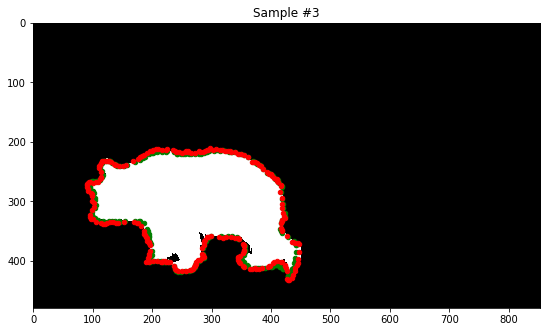

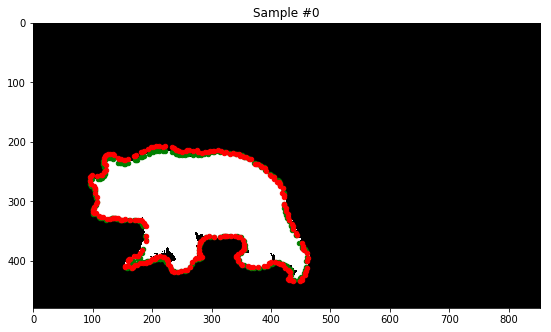

In [8]:
overfit_model.cpu()
overfit_model.double()
overfit_model.eval()
num_to_display = 2

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, num_val)
    data = train[rand_i]
    
    # Load corresponding image
    processed_file_name = train.processed_file_names[rand_i]
    folder = processed_file_name[:-11]
    augmentation_count = processed_file_name[-10:-9]
    file_name = processed_file_name[-8:-3]
    
    image_path = os.path.join(val.raw_paths[0], folder, augmentation_count,
                                ('{}{}'.format(file_name, '.png')))
    
    image = imageio.imread(image_path)
    
    with torch.no_grad():
        translation_pred = overfit_model(data)
        
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(image, data.contour, data.y, translation_pred)

### Train

In [9]:
train_loader = DataLoader(train, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=cfg.BATCH_SIZE, shuffle=False)

# Load model and run the solver
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

solver = Solver(optim_args={"lr": cfg.LEARNING_RATE,
                            "weight_decay": cfg.WEIGHT_DECAY})

solver.train(model, train_loader, val_loader,
             num_epochs=cfg.NUM_EPOCHS, log_nth=100, verbose=True)

torch.save(model.state_dict(), 'pg_models/trained_model.pth')

START TRAIN.
[Epoch 1/50] train_loss: 589.59323 - val_loss: 60.83246
[Epoch 2/50] train_loss: 42.74061 - val_loss: 49.36455
[Epoch 3/50] train_loss: 39.81035 - val_loss: 48.56121
[Epoch 4/50] train_loss: 38.34837 - val_loss: 48.33794
[Epoch 5/50] train_loss: 37.42744 - val_loss: 48.34425
[Epoch 6/50] train_loss: 36.47138 - val_loss: 48.25917
[Epoch 7/50] train_loss: 35.86246 - val_loss: 48.09872
[Epoch 8/50] train_loss: 35.39641 - val_loss: 47.98138
[Epoch 9/50] train_loss: 34.72707 - val_loss: 48.21099
[Epoch 10/50] train_loss: 34.13350 - val_loss: 48.12568
[Epoch 11/50] train_loss: 33.78559 - val_loss: 48.08374
[Epoch 12/50] train_loss: 33.20584 - val_loss: 48.12225
[Epoch 13/50] train_loss: 32.77900 - val_loss: 48.26200
[Epoch 14/50] train_loss: 32.28922 - val_loss: 48.42385
[Epoch 15/50] train_loss: 32.07341 - val_loss: 48.62343
[Epoch 16/50] train_loss: 31.61399 - val_loss: 48.70976
[Epoch 17/50] train_loss: 31.18132 - val_loss: 49.01623
[Epoch 18/50] train_loss: 30.83499 - val_lo

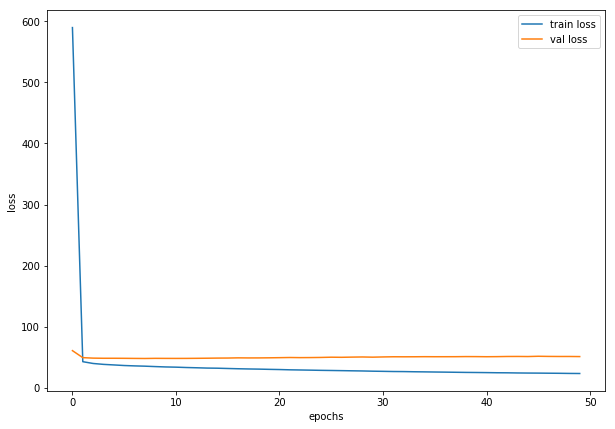

In [10]:
plot_loss(solver)

### Display trained outputs

In [11]:
model.cpu()
model.double()
model.eval()
num_to_display = 10

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(val))
    data = val[rand_i]
    
    # Load corresponding image
    processed_file_name = val.processed_file_names[rand_i]
    folder = processed_file_name[:-11]
    augmentation_count = processed_file_name[-10:-9]
    file_name = processed_file_name[-8:-3]
    
    image_path = os.path.join(val.raw_paths[0], folder, augmentation_count,
                                ('{}{}'.format(file_name, '.png')))
    
    image = imageio.imread(image_path)
    
    with torch.no_grad():
        translation_pred = model(data)
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(image, data.contour, data.y, translation_pred) 

AttributeError: 'GCN' object has no attribute 'conv4'

<Figure size 7200x720 with 0 Axes>

### Hyperparameter Tuning

In [ ]:
train_loader = DataLoader(train, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=cfg.BATCH_SIZE, shuffle=False)

learning_rates = [1e-2, 1e-4, 1e-6]
weight_decays = [1e-0, 1e-2, 1e-4]

best_model = None
best_loss = 1e10

i = 0
for learning_rate in learning_rates:
    if i == 0: break
    for weight_decay in weight_decays:
        model = GCN(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])
        solver = Solver(optim_args={"lr": LEARNING_RATE,
                            "weight_decay": WEIGHT_DECAY})
        solver.train(model, train_loader, val_loader,
             num_epochs=20, log_nth=100, verbose=False)

        # Predict on the validation set
        val_loss = max(solver.val_loss_history)
        print('Hyperparamter Tuning #', i + 1,
                'lr: ', learning_rate,
                'wd: ', weight_decay,
                'val_loss: ', val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

        i += 1